![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [271]:
import warnings
warnings.filterwarnings('ignore')

In [272]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [273]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [274]:
#bikes.to_excel("bikeshare.xlsx", index=False)

Variable "Total" (Respuesta): Conteo total de bicicletas rentadas incluyendo casuales y registradas.

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

### Celda 1.1

In [275]:
# Celda 1.1
gby_1 = bikes.groupby('season').total.mean()
gby_1 = gby_1.rename(index={1: 'Primavera', 2: 'Verano', 3: 'Otoño', 4: 'Invierno'})
gby_1

season
Primavera    116.343261
Verano       215.251372
Otoño        234.417124
Invierno     198.988296
Name: total, dtype: float64

Variable "Season":<br>
1: Primavera<br>
2: Verano<br>
3: Otoño<br>
4: Invierno<br>

#### Análisis:
El código anterior agrupa el dataframe por la variable "season" para cada uno de sus valores, y para las observaciones por valor, calcula el promedio de la variable respuesta "Total". Esto representa que para la temporada de primavera en promedio se rentan 116 bicicletas, en verano 215, otoño 234 y en invierno 198 bicicletas.

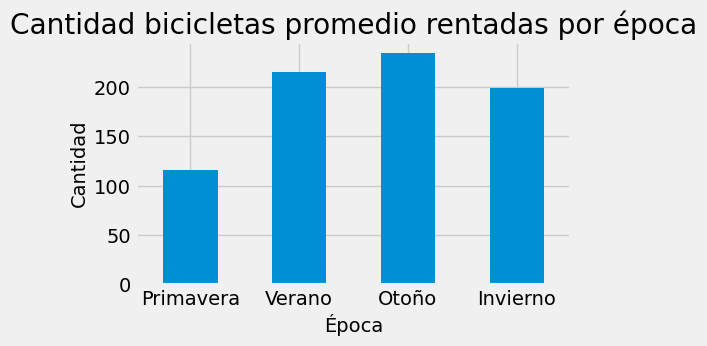

In [276]:
gby_1.plot(kind='bar',figsize=(5, 3))

plt.title('Cantidad bicicletas promedio rentadas por época')
plt.xlabel('Época')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x

plt.show()

#### Análisis:
Del gráfico anterior se puede identificar que en la época de otoño, es donde se renta en promedio una mayor cantidad de bicicletas, seguido de verano, invierno y por último primavera.

In [277]:
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


Se puede identificar que en cada época del año, mínimo se renta una bicicleta y máximo en primavera se rentan 801 bicicletas, verano 873, otoño 977 e invierno 948 bicicletas. La disperión de datos al rededor de la media en primavera es de 125,27, verano 192, otoño 197,15 e invierno 177,62. La mediana de renta de bicicletas en primavera es de 78 bicicletas, verano 172, otoño 195 e invierno 161 bicicletas, siendo la mediana el valor que separa cada conjunto de datos en dos partes iguales. Se identifica una mayor cantidad de registros en la época de invierno, seguido de verano y otoño, y por último primavera.

In [278]:
moda_gby1 = bikes.groupby('season')['total'].agg(lambda x: x.mode())
moda_gby1

season
1    2
2    5
3    5
4    5
Name: total, dtype: int64

El dato que más se repite para la cantidad de bicicletas rentadas en promedio en la época de primavera es 2 bicicletas, y 5 en las demás épocas.

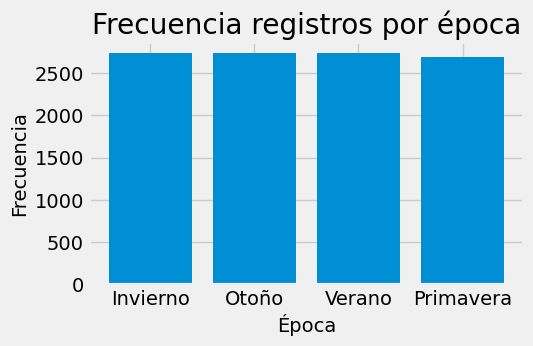

In [279]:
nuevas_etiquetas = ['Invierno','Otoño','Verano','Primavera']
conteo = bikes['season'].value_counts()
plt.figure(figsize=(5, 3))
plt.bar(nuevas_etiquetas, conteo.values)

plt.title('Frecuencia registros por época')
plt.xlabel('Época')
plt.ylabel('Frecuencia')

plt.show()

Se identifica una distribución equitativa de observaciones por época.

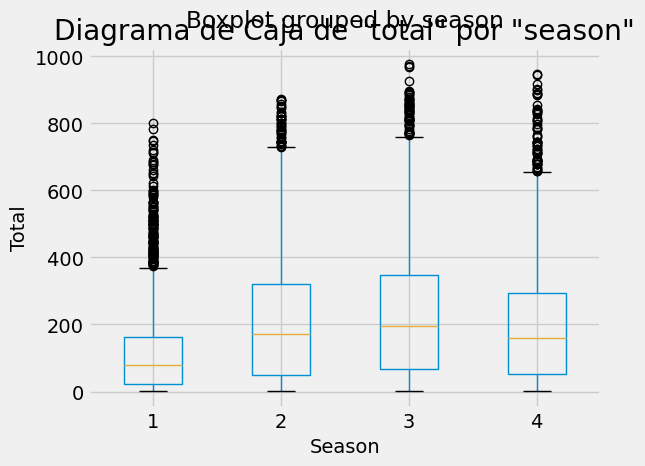

In [280]:
bikes.boxplot(column='total', by='season')

plt.title('Diagrama de Caja de "total" por "season"')
plt.xlabel('Season')
plt.ylabel('Total')

plt.show()

#### Análisis: 

Se identifica una mayor cantidad de datos atípicos en el grupo season 1, se identifica mayor dispersión en los datos del grupo season 3 al rededor de la media, y mucho menor en el grupo season 1, esto representa mayor variabilidad de datos en el grupo 3 y menor en el 1. Se identifica una dispersión mayor de los datos para los cuatro grupos más alla del tercel cuartil, es decir mayor dispersión en valores más altos de los conjuntos, y menor dispersión en valores bajos, de los conjuntos.

### Celda 1.2

In [281]:
# Celda 1.2
gby_2 = bikes.groupby('hour').total.mean()

In [282]:
numeros_enteros = range(0, 24)
horas = [datetime.time(h, 0) for h in numeros_enteros]
gby_2.index = horas
gby_2.index = [hora.strftime('%H:%M') for hora in gby_2.index]

#### Análisis:
El código anterior agrupa el dataframe por la variable "hour" para cada uno de sus valores, y para las observaciones por valor, calcula el promedio de la variable respuesta "Total". Esto representa el promedio de bicicletas que se rentan por cada hora del día.

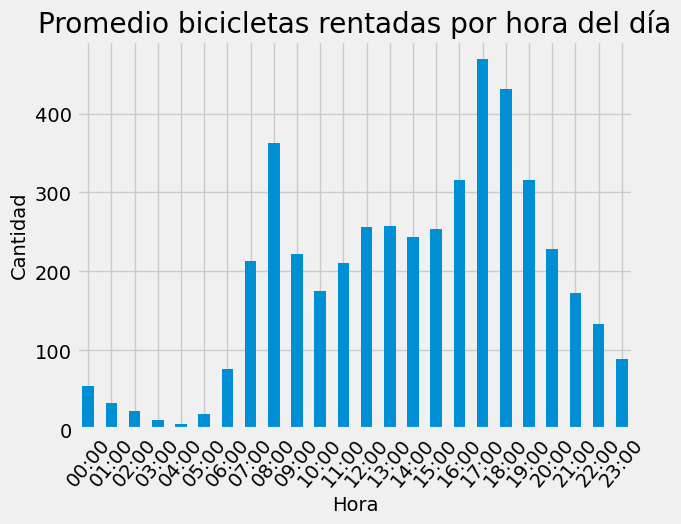

In [283]:
gby_2.plot(kind='bar')

plt.title('Promedio bicicletas rentadas por hora del día')
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.xticks(rotation=50)  # Rotar las etiquetas del eje x

plt.show()

#### Análisis:
Del gráfico anterior se puede identificar que las horas del día en las que en promedio se rentan una mayor cantidad de bicicletas son las 5:00 pm, 6:00 pm y 8:00 am.

In [284]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


#### Análisis: 

Se puede identificar la cantidad mínima de bicicletas que se rentan por hora del día, por ejemplo a las 6:00 pm, mínimo se rentan 23 bicicletas, se identifica la cantidad máxima de bicicletas rentadas por hora, como a las 6:00 pm con una cantidad de 977 bicicletas. Los datos de cantidad rentada de bicicletas a las 5:00 pm son los que tienen mayor desviación estandar, esto representa que los datos de esta grupo son los que más se alejan de su media. Se puede identificar la mediana de cada grupo de renta de bicicletas por hora.

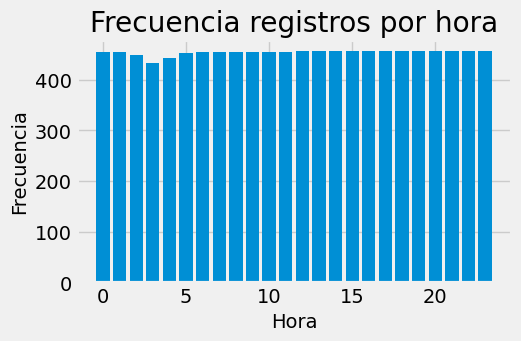

In [285]:
conteo = bikes['hour'].value_counts()
plt.figure(figsize=(5, 3))
plt.bar(conteo.index, conteo.values)

plt.title('Frecuencia registros por hora')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')

plt.show()

Se identifica una distribución equitativa de observaciones por hora.

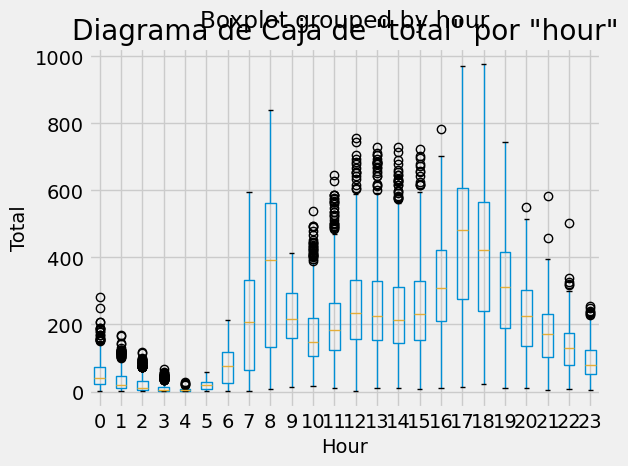

In [286]:
bikes.boxplot(column='total', by='hour')

plt.title('Diagrama de Caja de "total" por "hour"')
plt.xlabel('Hour')
plt.ylabel('Total')

plt.show()

#### Análisis:

Se identifica una mayor dispersión de datos al rededor de la media en horas como 8:00 am, 6:00 pm, 5:00 pm y 7:00 am. Se identifica mayor dispersión en valores altos para las horas 5:00 pm, 6:00 pm y 8:00 am. Se identifica una mayor cantidad de valores atípicos en el conjunto de horas de las 10 a las 15 horas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

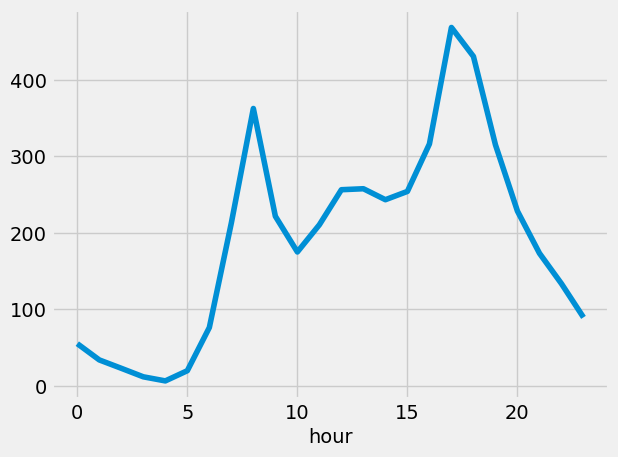

In [287]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

El código anterior agrupa el dataframe por la variable "hour" para cada uno de sus valores, y para las observaciones por valor, calcula el promedio de la variable respuesta "total". Esto representa el promedio de bicicletas que se rentan por cada hora del día.

<Axes: xlabel='hour'>

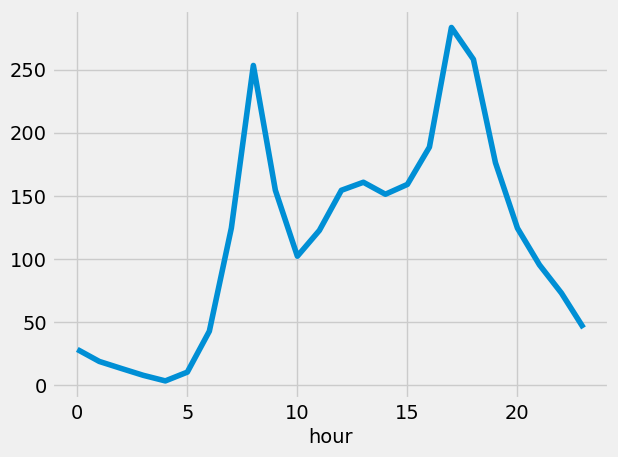

In [288]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour')['total'].mean().plot()

Cuando la variable "season" es igual a invierno, se identifica que en las horas pico (8:00 am y 6:00 pm), se rentan en promedio 250 y aproximadamente 280 bicicletas, respectivamente.

<Axes: xlabel='hour'>

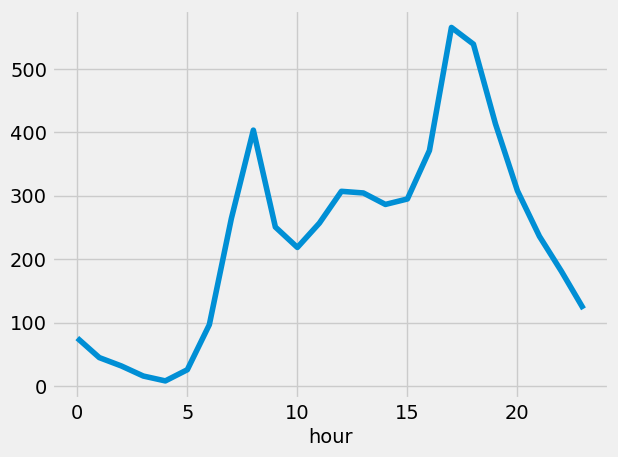

In [289]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour')['total'].mean().plot()

#### Análisis:

Cuando la variable "season" es igual a verano, se identifica que en las horas pico (8:00 am y 6:00 pm), se rentan en promedio 400 y aproximadamente 590 bicicletas, respectivamente. A partir de esto se puede inferir que la época del año influye en la cantidad total de bicicletas que las personas rentan por hora, estando esto relacionado probablemente con el clima que se genera en cada época.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [290]:
# Celda 3

In [291]:
XTotal = bikes[['season','hour']]
yTotal = bikes['total']

In [292]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [293]:
lr = LinearRegression()

In [294]:
lr.fit(XTrain,yTrain)

LinearRegression()

In [295]:
print('Coeficientes del modelo:', lr.coef_)
print('Intercepto:', lr.intercept_)

Coeficientes del modelo: [28.03619568 10.57944293]
Intercepto: -2.2398811285718807


#### Interpretación coeficientes:

lr.coef: Los coeficientes representan la magnitud del cambio en la variable respuesta o variable clase "total", por cada cambio en una unidad en la variable predictora correspondiente. Para este caso, estos coeficientes representan que por cada cambio unitario en la variable predictora season, hay un incremento de 28 unidades en la variable respuesta, esto es ilógico dada la naturaleza de la variable "season" que es categórica.

lr.intercept_ : El intercepto representa el punto de corte de la línea de regresión con el eje y. Cuando todas las variables predictoras son cero el valor predicho por el modelo es igual al intercepto. Para este caso, el punto de corte de la recta con el eje y, es en -2.23.

In [296]:
yPred = lr.predict(XTest)

In [297]:
lr_r2 = r2_score(yTest, yPred)

In [298]:
lr_r2

0.176885375076008

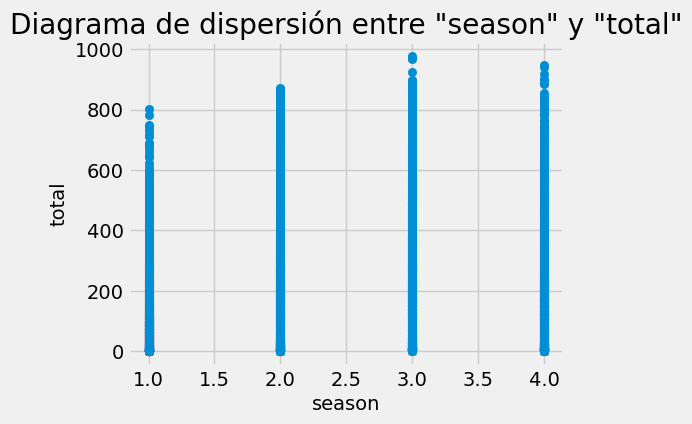

In [299]:
plt.figure(figsize=(5, 4))
plt.scatter(bikes['season'], bikes['total'])
plt.title('Diagrama de dispersión entre "season" y "total"')
plt.xlabel('season')
plt.ylabel('total')
plt.show()

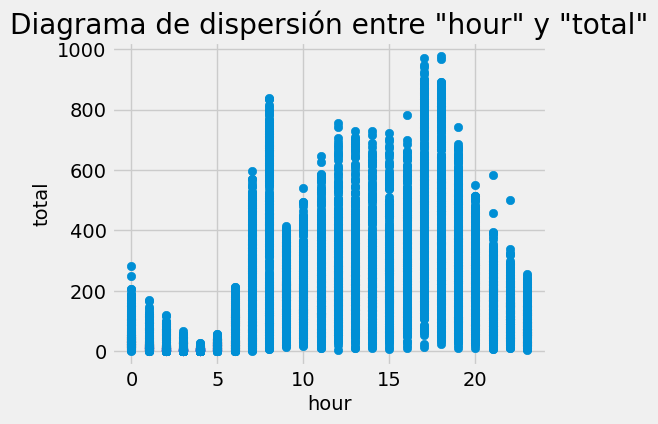

In [300]:
plt.figure(figsize=(5, 4))
plt.scatter(bikes['hour'], bikes['total'])
plt.title('Diagrama de dispersión entre "hour" y "total"')
plt.xlabel('hour')
plt.ylabel('total')
plt.show()

#### Limitación:

En este caso el modelo de regresión lineal multiple, asume una relación lineal entre la variable "season" y la variable respuesta "total", esto implica que trata el efecto de cada categoría como un incremento lineal y esto puede no reflejar la relación real entre estas dos variables. De igual manera entre la variable discreta "hour" y la variable "total". En las gráficas no se identifica relación lineal entre las variables predictoras y la variable respuesta.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [301]:
# Celda 4
bikes['total'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64

In [302]:
X = bikes[['season', 'hour']]
y = (bikes['total'] > 145).astype(int)

In [303]:
y

datetime
2011-01-01 00:00:00    0
2011-01-01 01:00:00    0
2011-01-01 02:00:00    0
2011-01-01 03:00:00    0
2011-01-01 04:00:00    0
                      ..
2012-12-19 19:00:00    1
2012-12-19 20:00:00    1
2012-12-19 21:00:00    1
2012-12-19 22:00:00    0
2012-12-19 23:00:00    0
Name: total, Length: 10886, dtype: int64

In [304]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [305]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [306]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [307]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 10)
j, split, gain

(1, 8.0, 0.16178755449047394)

In [308]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [309]:
y.shape[0], y_l.shape[0], y_r.shape[0] #Nivel 1

(10886, 3594, 7292)

In [310]:
y.mean(), y_l.mean(), y_r.mean()

(0.49917325004593055, 0.09404563160823595, 0.6988480526604498)

In [311]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [312]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [313]:
def count_nodes(tree):
    # Si el árbol está vacío, retornar 0
    if tree is None:
        return 0
    
    # Contar el nodo actual y los nodos hijos recursivamente
    count = 1  # Contador para el nodo actual
    if 'sl' in tree:  # Si hay un nodo hijo izquierdo
        count += count_nodes(tree['sl'])  # Contar nodos en el subárbol izquierdo
    if 'sr' in tree:  # Si hay un nodo hijo derecho
        count += count_nodes(tree['sr'])  # Contar nodos en el subárbol derecho
    
    return count

# Llamar a la función para contar los nodos en el árbol
num_nodes = count_nodes(tree)
print("Número total de nodos en el árbol:", num_nodes)

Número total de nodos en el árbol: 15


In [314]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [315]:
# Ejecución de función tree_predict
yPred = tree_predict(X, tree)
yPred

array([0., 0., 0., ..., 1., 0., 0.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [316]:
# Celda 5

In [317]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 10)

In [318]:
# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

In [319]:
XTotal = bikes[['season', 'hour']]
yTotal = (bikes['total'] > 145).astype(int)

In [320]:
# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, XTotal, yTotal, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

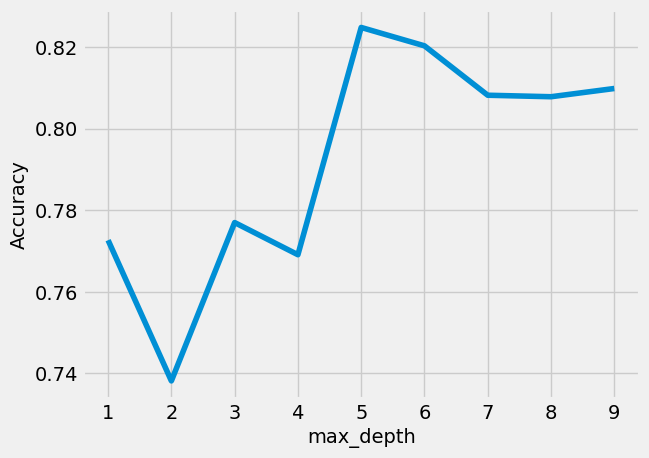

In [321]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [322]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.824853987738346, 5)

In [323]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [324]:
# max_depth=5 fue el mejor, se ajusta un árbol usando este valor 
clfTree = DecisionTreeClassifier(max_depth=5, random_state=1)

In [325]:
clfTree.fit(XTrain, yTrain)

DecisionTreeClassifier(max_depth=5, random_state=1)

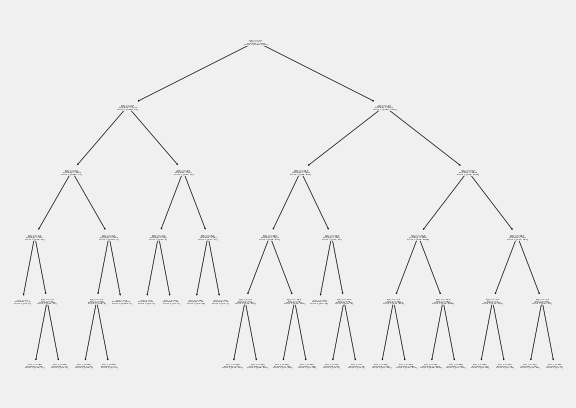

In [326]:
plot_tree(clfTree)
plt.show()

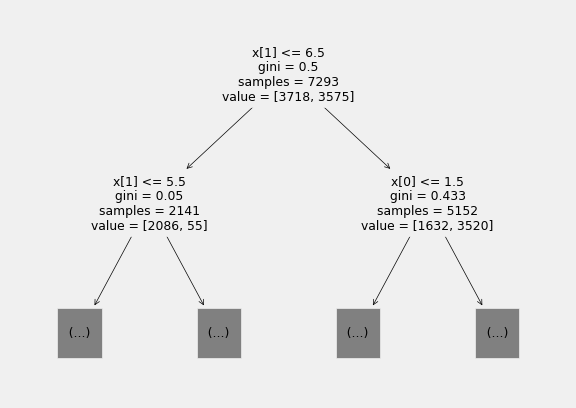

In [327]:
plot_tree(clfTree,max_depth=1)
plt.show()

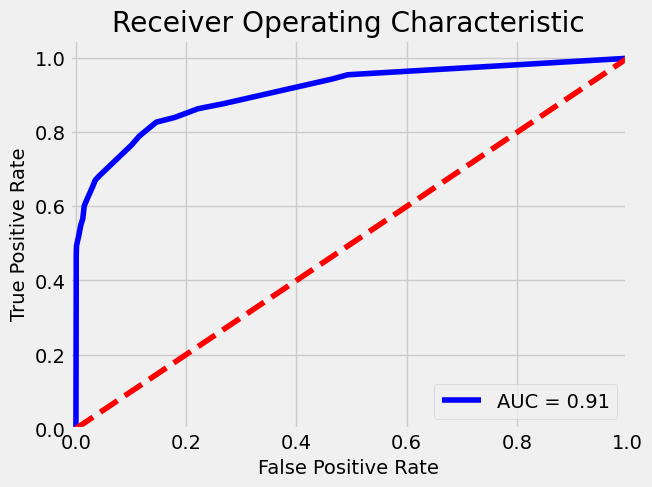

In [328]:
prediccionTree=clfTree.predict_proba(XTest)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionTree, pos_label=0)
AUCTree=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [329]:
feature_cols = XTrain.columns

In [330]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clfTree.feature_importances_}).sort_values('importance')

,feature,importance
0,season,0.159375
1,hour,0.840625


In [331]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clfTree, XTotal, yTotal, cv=10)).describe()

count    10.000000
mean      0.824854
std       0.147466
min       0.449036
25%       0.805785
50%       0.883330
75%       0.910386
max       0.947610
dtype: float64

### Análisis:

De acuerdo al valor del AUC generado por el modelo con un valor de 0.91, el arbol de clasificación con una profundidad máxima de 5, tiene un rendimiento bueno. En comparación con el modelo de regresión lineal que tiene una precisión muy baja, dado que no existen relaciones lineales entre las variables predictoras "season" y "hour" con "total", el modelo de clasificación se ajusta mejor a lo datos, en este caso sobre los datos de entrenamiento, encontrando patrones en estos, y tiene una capacidad correcta para predecir datos no vistos, como se puede evidenciar al realizar predicciones con XTest, y comparar con yTest.

## Árbol de regresión:

In [332]:
XTotal = bikes[['season', 'hour']]
yTotal = bikes['total']

In [333]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [334]:
tree_reg = DecisionTreeRegressor(random_state=1)
tree_reg.fit(XTrain, yTrain)

DecisionTreeRegressor(random_state=1)

In [335]:
yPred = tree_reg.predict(XTest)

In [336]:
mse = mean_squared_error(yTest, yPred)
print("Error cuadrático medio:", mse)

Error cuadrático medio: 13395.201994797595


In [337]:
r2 = r2_score(yTest, yPred)
print("Coeficiente de determinación (R^2):", r2)

Coeficiente de determinación (R^2): 0.5900527074203806


### Conclusión:

Se puede evidenciar que el árbol de regresión tiene mejor desempeñor que el modelo de regresión lineal, de acuerdo al valor obtenido para el r2, 0.59 y 0.17 respectivamente. Sin embargo, queda en evidencia que al utilizar los datos de las variables "season" y "hour", para clasificación, tiene un mejor desempeño el árbol de clasificación.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [338]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [339]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [340]:
X.dtypes

timedelta                        float64
n_tokens_title                   float64
n_tokens_content                 float64
n_unique_tokens                  float64
n_non_stop_words                 float64
n_non_stop_unique_tokens         float64
num_hrefs                        float64
num_self_hrefs                   float64
num_imgs                         float64
num_videos                       float64
average_token_length             float64
num_keywords                     float64
data_channel_is_lifestyle        float64
data_channel_is_entertainment    float64
data_channel_is_bus              float64
data_channel_is_socmed           float64
data_channel_is_tech             float64
data_channel_is_world            float64
kw_min_min                       float64
kw_max_min                       float64
kw_avg_min                       float64
kw_min_max                       float64
kw_max_max                       float64
kw_avg_max                       float64
kw_min_avg      

In [341]:
y

0       1
1       0
2       0
3       0
4       0
       ..
5995    0
5996    1
5997    0
5998    0
5999    1
Name: Popular, Length: 6000, dtype: int64

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

#### Árbol de clasificación:

In [342]:
# Celda 6

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 10)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

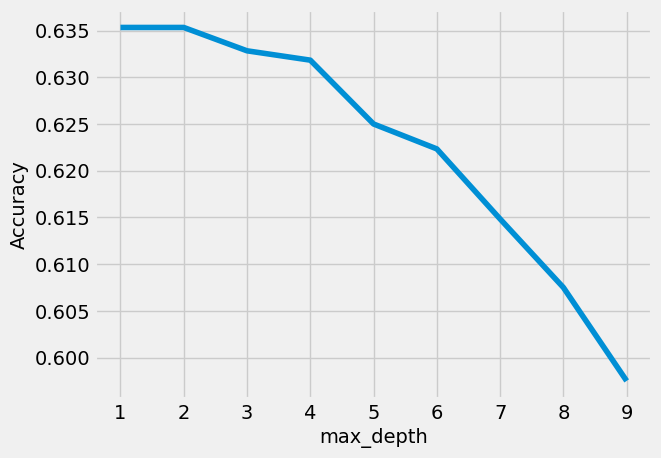

In [343]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [344]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6353333333333333, 2)

In [345]:
# División de la muestra en set de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [346]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

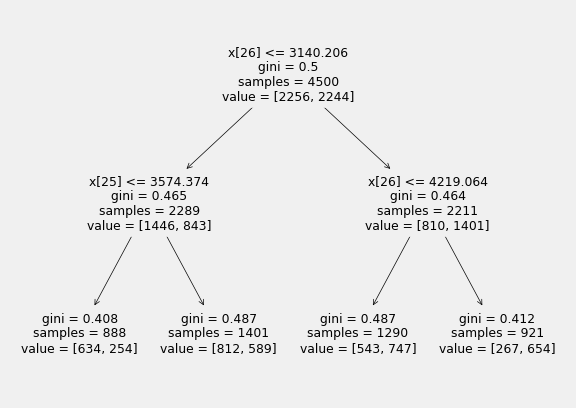

In [347]:
plot_tree(clf)
plt.show()

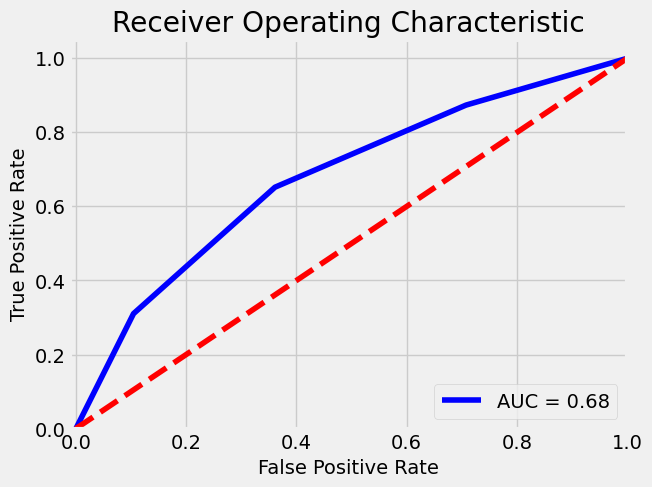

In [348]:
prediccionTree=clf.predict_proba(X_test)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediccionTree, pos_label=0)
AUCTree=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [349]:
prediccionTree=clf.predict(X_test)
prediccionTree

array([1, 1, 1, ..., 1, 0, 0])

In [350]:
print("Matriz de confusión: ")
print("")
print(confusion_matrix(y_true=y_test, y_pred=prediccionTree))

Matriz de confusión: 

[[485 259]
 [273 483]]


In [351]:
print("Accuracy: ")
print("")
accuracyClf=accuracy_score(y_true=y_test, y_pred=prediccionTree)
print(accuracyClf)

Accuracy: 

0.6453333333333333


In [352]:
print("F1-score: ")
print("")
f1Clf = f1_score(y_true=y_test, y_pred=prediccionTree)
print(f1Clf)

F1-score: 

0.6448598130841121


In [353]:
feature_cols = X_train.columns

In [354]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
#pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

#### Regresión logística:

In [355]:
XTotal = df.drop(['url', 'Popular'], axis=1)
yTotal = df['Popular']

In [356]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [357]:
clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(XTrain,yTrain)

LogisticRegression(max_iter=10000, random_state=0)

In [358]:
prediccionesRegLog=clfRegLog.predict(XTest)
prediccionesProbRegLog=clfRegLog.predict_proba(XTest)

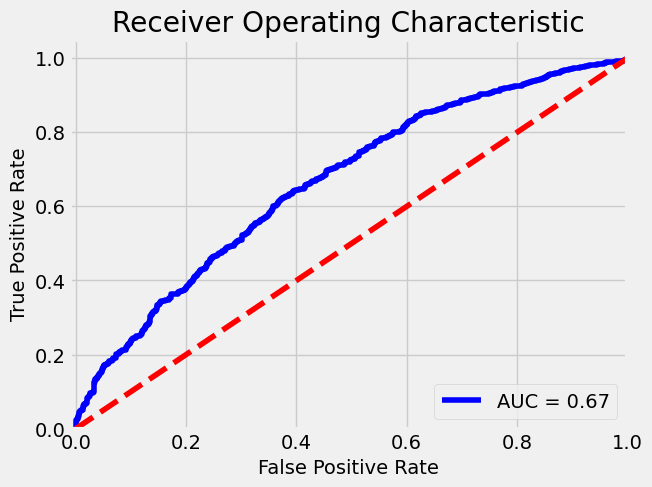

In [359]:
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionesProbRegLog[:,1], pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [360]:
print("Matriz de confusión: ")
print("")
print(confusion_matrix(y_true=yTest, y_pred=prediccionesRegLog))

Matriz de confusión: 

[[625 362]
 [387 606]]


In [361]:
print("Accuracy: ")
print("")
accuracyRegLog=accuracy_score(y_true=yTest, y_pred=prediccionesRegLog)
print(accuracyRegLog)

Accuracy: 

0.6217171717171717


In [362]:
print("F1-score: ")
print("")
f1RegLog = f1_score(y_true=yTest, y_pred=prediccionesRegLog)
print(f1RegLog)

F1-score: 

0.6180520142784294


## Comparación de árbol de clasificación y regresión logística: 

In [363]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3000, 3000]))

In [364]:
np.unique(yTotal, return_counts=True)

(array([0, 1]), array([3000, 3000]))

In [365]:
print("Accuracy árbol de clasificación: "+str(accuracyClf))
print("Accuracy regresión logística: "+str(accuracyRegLog))

Accuracy árbol de clasificación: 0.6453333333333333
Accuracy regresión logística: 0.6217171717171717


In [366]:
print("F1-score árbol de clasificación: "+str(f1Clf))
print("F1-score regresión logística: "+str(f1RegLog))

F1-score árbol de clasificación: 0.6448598130841121
F1-score regresión logística: 0.6180520142784294


Se pueden identificar valores similares tanto para accuracy como f1-score para ambos modelos. El accuracy expresa la proporción de predicciones correctas sobre el total de predicciones, en este caso para ambos modelos, estos clasificaron en un 64% de las veces, correctamente la variable respuesta. El valor del f1-score en este caso expresa el equilibrio entre precision y recall para los modelos, siendo precision una métrica que indica la proporción de predicciones positivas reales sobre todas las predicciones positivas realizadas por el modelo, y el recall una métrica que indica la proporción de predicciones positivas reales sobre total casos positivos reales. Para este caso el f1-score indica un rendimiento moderado en términos de la capacidad para hacer predicciones precisas y exhaustivas, en cuanto a la cantidad de veces que predice correctamente una etiqueta como positiva.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [367]:
# Celda 7

In [368]:
XTotal = df.drop(['url', 'Popular'], axis=1)
yTotal = df['Popular']

In [369]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [370]:
# 1. 100 muestras de árboles de decisión donde max_depth tome un valor de su elección

np.random.seed(123)

n_samples = XTrain.shape[0]
n_B = 100

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )] #indices de observaciones

In [371]:
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_B)

trees = {}
for i in range(n_B):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=40, random_state=seeds[i])
    trees[i].fit(XTrain.iloc[samples[i]], yTrain.iloc[samples[i]])

In [372]:
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=XTest.index, columns=list(range(n_B)))
for i in range(n_B):
    y_pred_df.iloc[:, i] = trees[i].predict(XTest)

y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4320,1,0,1,1,1,1,0,1,1,1,...,1,1,1,0,0,1,0,1,0,0
2006,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,1,1,0,1,0,0
5689,1,1,0,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0,1,1
472,1,1,1,0,0,1,1,0,1,1,...,0,0,1,1,1,1,0,1,1,0
1370,1,0,0,1,1,1,1,1,0,1,...,1,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,1,1,1,1,0,1,1,1,0,1,...,0,0,1,1,1,1,1,1,1,0
3485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2425,1,1,1,0,0,1,1,1,1,0,...,1,1,0,1,0,1,0,1,0,1
2640,1,1,0,0,1,0,1,1,0,0,...,0,1,1,0,0,1,1,0,1,0


In [373]:
# Votación mayoritaria
y_pred_vm = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [374]:
f1score_modelo_dt_vm = metrics.f1_score(y_pred_vm, yTest)
accuracy_modelo_dt_vm = metrics.accuracy_score(y_pred_vm, yTest)

print("F1-score del modelo árbol de decisión 1: "+str(f1score_modelo_dt_vm))
print("Accuracy del modelo árbol de decisión 1: "+str(accuracy_modelo_dt_vm))

F1-score del modelo árbol de decisión 1: 0.6519607843137255
Accuracy del modelo árbol de decisión 1: 0.6414141414141414


In [375]:
# 2. 100 muestras de árboles de decisión donde min_samples_leaf tome un valor de su elección

np.random.seed(123)

n_samples = XTrain.shape[0]
n_B = 100

samples2 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [376]:
np.random.seed(123) 
seeds2 = np.random.randint(1, 10000, size=n_B)

trees2 = {}
for i in range(n_B):
    trees2[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None,min_samples_leaf=10,random_state=seeds2[i])
    trees2[i].fit(XTrain.iloc[samples2[i]], yTrain.iloc[samples2[i]])

In [377]:
# Predicción para los datos del set de test con cada modelo
y_pred_df2 = pd.DataFrame(index=XTest.index, columns=list(range(n_B)))
for i in range(n_B):
    y_pred_df2.iloc[:, i] = trees2[i].predict(XTest)

y_pred_df2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4320,0,1,1,0,0,1,0,0,1,1,...,1,0,1,0,1,1,0,0,1,1
2006,0,1,1,1,1,0,0,1,1,0,...,1,1,1,0,0,1,0,0,0,1
5689,1,0,1,1,0,0,1,1,1,1,...,0,0,1,0,0,1,0,1,1,0
472,1,1,1,0,0,0,1,1,0,0,...,1,0,1,1,1,1,1,1,0,0
1370,0,1,0,0,0,1,0,1,0,0,...,1,1,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,0,1,0,0,1,1,1,1,1,1,...,0,0,1,0,1,1,1,0,0,1
3485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2425,0,0,1,1,0,0,1,1,0,0,...,0,1,1,1,1,1,1,0,0,0
2640,1,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [378]:
# Votación mayoritaria
y_pred_vm2 = (y_pred_df2.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [379]:
f1score_modelo_dt2_vm = metrics.f1_score(y_pred_vm2, yTest)
accuracy_modelo_dt2_vm = metrics.accuracy_score(y_pred_vm2, yTest)

print("F1-score del modelo árbol de decisión 2: "+str(f1score_modelo_dt2_vm))
print("Accuracy del modelo árbol de decisión 2: "+str(accuracy_modelo_dt2_vm))

F1-score del modelo árbol de decisión 2: 0.6503251625812906
Accuracy del modelo árbol de decisión 2: 0.646969696969697


In [380]:
# 3. 100 muestras de regresión logística:

np.random.seed(123)

n_samples = XTrain.shape[0]
n_B = 100

samples3 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [381]:
np.random.seed(123) 
seeds3 = np.random.randint(1, 10000, size=n_B)

reglog3 = {}
for i in range(n_B):
    reglog3[i] = LogisticRegression(random_state=seeds3[i])
    reglog3[i].fit(XTrain.iloc[samples3[i]], yTrain.iloc[samples3[i]])

In [382]:
# Predicción para los datos del set de test con cada modelo
y_pred_df3 = pd.DataFrame(index=XTest.index, columns=list(range(n_B)))
for i in range(n_B):
    y_pred_df3.iloc[:, i] = reglog3[i].predict(XTest)

y_pred_df3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2006,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5689,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
472,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1370,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2425,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2640,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,0,0,1,1,0,1


In [383]:
# Votación mayoritaria
y_pred_vm3 = (y_pred_df3.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [384]:
f1score_modelo_lr_vm = metrics.f1_score(y_pred_vm3, yTest)
accuracy_modelo_lr_vm = metrics.accuracy_score(y_pred_vm3, yTest)

print("F1-score del modelo regresión logística: "+str(f1score_modelo_lr_vm))
print("Accuracy del modelo regresión logística: "+str(accuracy_modelo_lr_vm))

F1-score del modelo regresión logística: 0.6229674796747967
Accuracy del modelo regresión logística: 0.6252525252525253


In [385]:
# Aplicar votación mayoritaria
final_pred = []
for i in range(len(XTest)):
    final_pred.append(mode([y_pred_vm.iloc[i], y_pred_vm2.iloc[i], y_pred_vm3.iloc[i]]))

In [386]:
f1score_vm = metrics.f1_score(final_pred, yTest)
accuracy_vm = metrics.accuracy_score(final_pred, yTest)

In [387]:
print("F1-score del modelo de ensamblaje: "+str(f1score_vm))
print("Accuracy del modelo de ensamblaje: "+str(accuracy_vm))

F1-score del modelo de ensamblaje: 0.654037886340977
Accuracy del modelo de ensamblaje: 0.6494949494949495


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [388]:
# Celda 8

In [389]:
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

In [390]:
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_B)

for i in range(n_B):
    y_pred_ = trees[i].predict(XTrain.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(yTrain.iloc[samples_oob[i]], y_pred_)

Text(0.5, 1.0, 'OOB error of each tree')

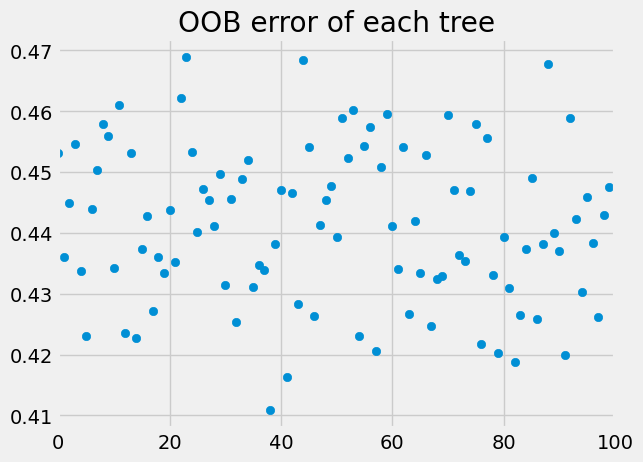

In [391]:
# Visualización de OOB para cada árbol
plt.style.use('fivethirtyeight')

plt.scatter(range(n_B), errors)
plt.xlim([0, n_B])
plt.title('OOB error of each tree')

In [392]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

In [393]:
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)

4320    0.447598
2006    0.559041
5689    0.559009
472     0.671885
1370    0.560272
1457    0.729639
5783    0.460492
3484    0.628683
1145    0.698001
130     0.552350
1136    0.479953
4658    0.369062
1161    0.679466
2152    0.340526
559     0.449181
916     0.180283
4278    0.351587
4394    0.341236
4008    0.338433
4910    0.670451
dtype: float64

In [394]:
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

In [395]:
f1score_modelo_dt1_vp = metrics.f1_score(y_pred, yTest)
accuracy_modelo_dt1_vp = metrics.accuracy_score(y_pred, yTest)

print("F1-score del modelo 1: "+str(f1score_modelo_dt1_vp))
print("Accuracy del modelo 1: "+str(accuracy_modelo_dt1_vp))

F1-score del modelo 1: 0.6478174603174603
Accuracy del modelo 1: 0.6414141414141414


In [396]:
# Árbol decisión 2

samples_oob2 = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples2:
    samples_oob2.append(sorted(set(range(n_samples)) - set(sample)))

In [397]:
# Estimación de los errores OOB para cada clasificador
errors2 = np.zeros(n_B)

for i in range(n_B):
    y_pred_2 = trees2[i].predict(XTrain.iloc[samples_oob2[i]])
    errors2[i] = 1 - metrics.accuracy_score(yTrain.iloc[samples_oob2[i]], y_pred_2)

Text(0.5, 1.0, 'OOB error of each tree in second model')

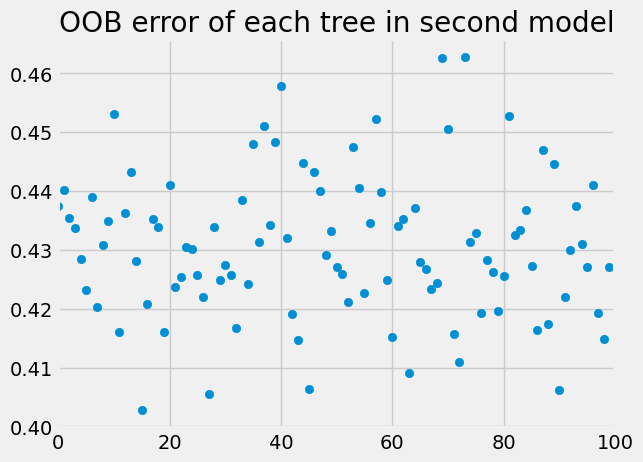

In [398]:
# Visualización de OOB para cada árbol modelo 2
plt.style.use('fivethirtyeight')

plt.scatter(range(n_B), errors2)
plt.xlim([0, n_B])
plt.title('OOB error of each tree in second model')

In [399]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha2 = (1 - errors2) / (1 - errors2).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1_2 = ((y_pred_df2) * alpha2).sum(axis=1)
weighted_sum_1_2.head(20)

# Desempeño al hacer votación ponderada
y_pred2 = (weighted_sum_1_2 >= 0.5).astype(np.int)

f1score_modelo_dt2_vp = metrics.f1_score(y_pred2, yTest)
accuracy_modelo_dt2_vp = metrics.accuracy_score(y_pred2, yTest)

print("F1-score del modelo 2: "+str(f1score_modelo_dt2_vp))
print("Accuracy del modelo 2: "+str(accuracy_modelo_dt2_vp))

F1-score del modelo 2: 0.6450632911392405
Accuracy del modelo 2: 0.645959595959596


In [400]:
# Regresión logística

samples_oob3 = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples3:
    samples_oob3.append(sorted(set(range(n_samples)) - set(sample)))

In [401]:
# Estimación de los errores OOB para cada clasificador
errors3= np.zeros(n_B)

for i in range(n_B):
    y_pred_3 = reglog3[i].predict(XTrain.iloc[samples_oob3[i]])
    errors3[i] = 1 - metrics.accuracy_score(yTrain.iloc[samples_oob3[i]], y_pred_3)

Text(0.5, 1.0, 'OOB error of each tree in third model')

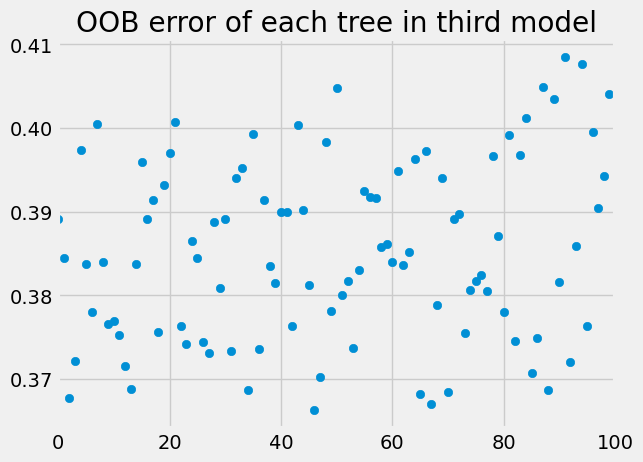

In [402]:
# Visualización de OOB para cada regresión lineal del modelo 3
plt.style.use('fivethirtyeight')

plt.scatter(range(n_B), errors3)
plt.xlim([0, n_B])
plt.title('OOB error of each tree in third model')

In [403]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha3 = (1 - errors3) / (1 - errors3).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1_3 = ((y_pred_df3) * alpha3).sum(axis=1)
weighted_sum_1_3.head(20)

# Desempeño al hacer votación ponderada
y_pred3 = (weighted_sum_1_3 >= 0.5).astype(np.int)

f1score_modelo_lr_vp = metrics.f1_score(y_pred3, yTest)
accuracy_modelo_lr_vp = metrics.accuracy_score(y_pred3, yTest)

print("F1-score del modelo 3: "+str(f1score_modelo_lr_vp))
print("Accuracy del modelo 3: "+str(accuracy_modelo_lr_vp))

F1-score del modelo 3: 0.6225839267548322
Accuracy del modelo 3: 0.6252525252525253


In [404]:
final_pred_vp = []
for i in range(len(XTest)):
    final_pred_vp.append(mode([y_pred.iloc[i], y_pred2.iloc[i], y_pred3.iloc[i]]))
    
f1score_vp = metrics.f1_score(final_pred_vp, yTest)
accuracy_vp = metrics.accuracy_score(final_pred_vp, yTest)

print("F1-score del modelo de ensamblaje: "+str(f1score_vp))
print("Accuracy del modelo de ensamblaje: "+str(accuracy_vp))

F1-score del modelo de ensamblaje: 0.6488664987405541
Accuracy del modelo de ensamblaje: 0.647979797979798


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [405]:
# Celda 9

<Figure size 640x480 with 0 Axes>

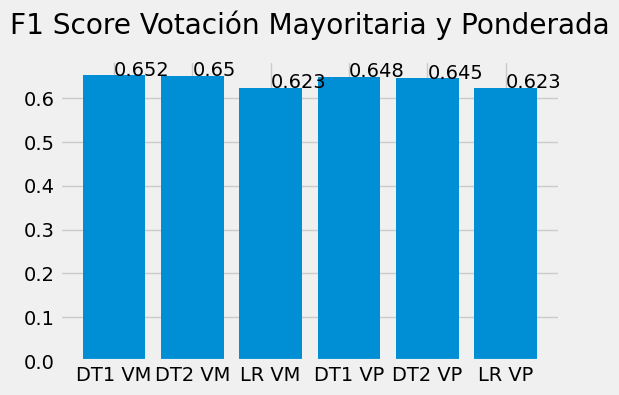

In [406]:
fig = plt.figure()
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1 Score Votación Mayoritaria y Ponderada", pad=20)
ejeX = ['DT1 VM', 'DT2 VM','LR VM','DT1 VP', 'DT2 VP','LR VP']
ejeY = [round(f1score_modelo_dt_vm,3),round(f1score_modelo_dt2_vm,3),round(f1score_modelo_lr_vm,3),round(f1score_modelo_dt1_vp,3),round(f1score_modelo_dt2_vp,3),round(f1score_modelo_lr_vp,3)]

ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.show()

<Figure size 640x480 with 0 Axes>

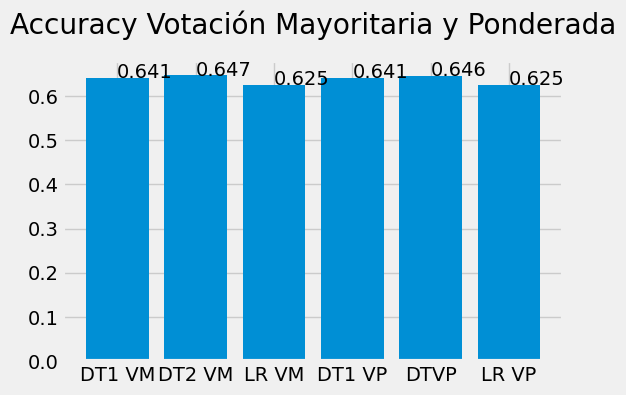

In [407]:
fig = plt.figure()
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Accuracy Votación Mayoritaria y Ponderada", pad=20)
ejeX = ['DT1 VM', 'DT2 VM','LR VM','DT1 VP', 'DTVP','LR VP']
ejeY = [round(accuracy_modelo_dt_vm,3),round(accuracy_modelo_dt2_vm,3),round(accuracy_modelo_lr_vm,3),round(accuracy_modelo_dt1_vp,3),round(accuracy_modelo_dt2_vp,3),round(accuracy_modelo_lr_vp,3)]

ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.show()

<Figure size 640x480 with 0 Axes>

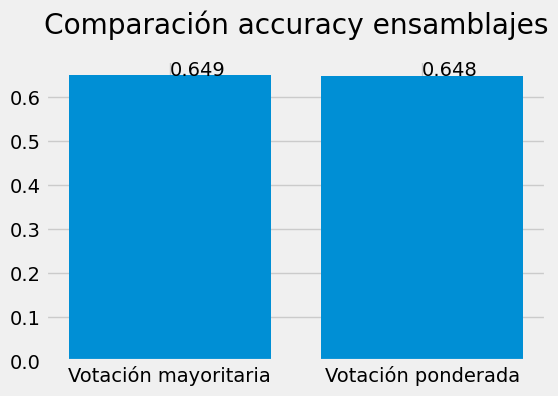

In [408]:
fig = plt.figure()
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación accuracy ensamblajes", pad=20)
ejeX = ['Votación mayoritaria', 'Votación ponderada']
ejeY = [round(accuracy_vm,3),round(accuracy_vp,3)]

ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.show()

<Figure size 640x480 with 0 Axes>

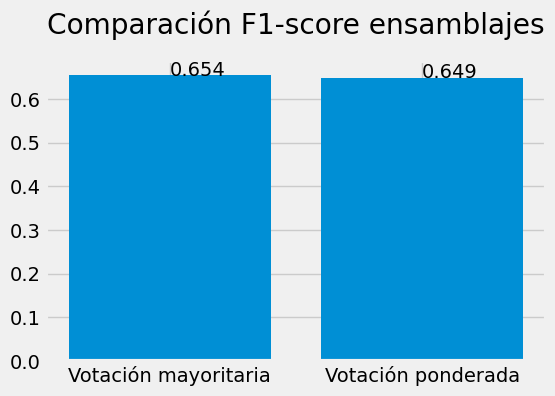

In [409]:
fig = plt.figure()
fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación F1-score ensamblajes", pad=20)
ejeX = ['Votación mayoritaria', 'Votación ponderada']
ejeY = [round(f1score_vm,3),round(f1score_vp,3)]

ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)

plt.show()

## Conclusión:

El ensamblaje de modelo con votación mayoritaria tiene un poco más de rendimiento que el modelo de ensamblaje con votación ponderada, esto se refleja en la comparación de f1-score para cada uno. De igual manera el modelo de ensamblaje con votación mayoritaria tiene un poco más de precisión que el ensamblaje con votación ponderada. Esto representa que el ensamblaje con votación mayoritaria, tiene un poco más de precisión al predecir valores positivos.

Entre las ventajas de los modelos de ensamblaje con votación mayoritaria, la votación mayoritaria tiende a reducir el riesgo de sobreajuste, ya que la decisión final no depende de un solo modelo. Entre las ventajas de ensamblajes con votación ponderada, permite asignar diferentes ponderaciones a cada modelo base, según su rendimiento. Esto genera mayor precisión al priorizar modelos más confiables. Entre las desventajas de los modelos de ensamblaje con votación mayoritaria, no se tiene en cuenta toda la información de la muestra de entrenamiento y no tiene en cuenta la calidad de las predicciones individuales de cada modelo base. En el modelo de ensamblaje por votación ponderada, si se ajustan demasiado los pesos a los datos de entrenamiento, se puede generar sobreajuste.